In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/waterQuality/all4classes.csv')

In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,body,Subjectivity,Polarity,Analysis,cod
0,0,0,0,predatory white pointers dingos saltwatercrocs...,0.075066,0.075066,Positive,0
1,1,1,1,this january simply note that are still having...,0.000000,0.000000,Neutral,0
2,2,2,2,pronouns hehim height zodiac sign leo smoke he...,0.000000,0.000000,Neutral,0
3,3,3,3,pronouns hehim height zodiac sign sagittarius ...,-0.075000,-0.075000,Negative,0
4,4,4,4,hoses are inchworm water lilies are powderblue...,-0.166667,-0.166667,Negative,0


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split()))

In [ ]:
print('Info about training data:')
print(train_data['cod'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
2    5572
0    5032
1    4825
3    4395
Name: cod, dtype: int64
Total comments:  19824


In [ ]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :52


In [ ]:
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[11, 1, 1, 667]]


In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['cod'],\
                                                      test_size=0.2,\
                                                      random_state=0)

In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-9ee80a7500df>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-9ee80a7500df>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[0, 1, 2, 3]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [ ]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

15359    2
7610     1
7352     1
13426    2
9179     1
15439    3
12826    2
3630     0
2632     0
7851     1
Name: cod, dtype: int64
Text to number
[2 1 1 2 1 3 2 0 0 1]
Number to category
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
# looking for top 30k comments
max_features = 250000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(4,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           16000000  
                                                                 
 lstm (LSTM)                 (None, 256, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [ ]:
# Training model
epochs = 20
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/20
496/496 [==============================] - 500s 998ms/step - loss: 1.8736 - categorical_accuracy: 0.2798 - auc: 0.5300 - val_loss: 1.4926 - val_categorical_accuracy: 0.2752 - val_auc: 0.5223
Epoch 2/20
496/496 [==============================] - 491s 989ms/step - loss: 1.4409 - categorical_accuracy: 0.2826 - auc: 0.5326 - val_loss: 1.4094 - val_categorical_accuracy: 0.2752 - val_auc: 0.5223
Epoch 3/20
496/496 [==============================] - 492s 992ms/step - loss: 1.3940 - categorical_accuracy: 0.2826 - auc: 0.5338 - val_loss: 1.3888 - val_categorical_accuracy: 0.2752 - val_auc: 0.5223
Epoch 4/20
496/496 [==============================] - 491s 989ms/step - loss: 1.3842 - categorical_accuracy: 0.2826 - auc: 0.5330 - val_loss: 1.3856 - val_categorical_accuracy: 0.2752 - val_auc: 0.5223
Epoch 5/20
496/496 [==============================] - 490s 988ms/step - loss: 1.3828 - categorical_accuracy: 0.2826 - auc: 0.5333 - val_loss: 1.3851 - val_categorical_accuracy: 0.2752 - val_au

KeyboardInterrupt: ignored

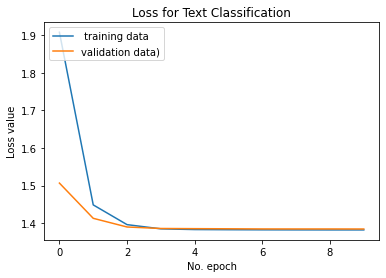

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

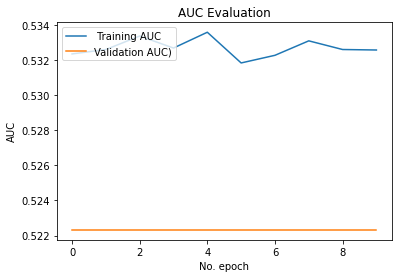

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-21-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [ ]:
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
124/124 [==============================] - 8s 62ms/step


array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
y_test.shape
y_test

11838    2
8942     1
3494     0
3261     0
8434     1
        ..
7803     1
19595    3
16312    3
9366     1
13671    2
Name: cod, Length: 3965, dtype: int64

In [ ]:
labels = [0, 1, 2, 3]
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       972
           1       0.00      0.00      0.00       996
           2       0.28      1.00      0.43      1091
           3       0.00      0.00      0.00       906

    accuracy                           0.28      3965
   macro avg       0.07      0.25      0.11      3965
weighted avg       0.08      0.28      0.12      3965



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
